In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

the CD4069UB device consist of six CMOS inverter circuits. these devices are intended for all generalpurpose inverter applications where the mediumpower TTL-drive and logic-level-conversion. this device is not ideal for linear amplification, but can be used as such and will add a lot of soft-clipping. soft-clipping is expected from a valve. this makes this device special for musical usage and can be found in guitar distortion pedals [[2](http://www.runoffgroove.com/ubescreamer.html)] or the wasp filter [[3](https://www.schmitzbits.de/wasp.html)]. in this article series i want to investigate this device and find out if new modules can be built with it.

**the chip should be powered by +5V/GND. With higher voltage the heat dissipation will be to big and the chip will be damaged.**

## voltage follower
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

the simplest circuit to begin with is a voltage follower or buffer. the buffer confifuration looks similar to the opamp buffer. but there are some differences. the first important difference is that the feedback will also do the biasing of the input signal. when an ac signal is applied to the buffer the output will be a dc signal, as long as the chip is able to provide the needed biasing feedback. the gain can be calculated similar to the opamp configuration. but there will be less gain as we would excpect from the calculation. 

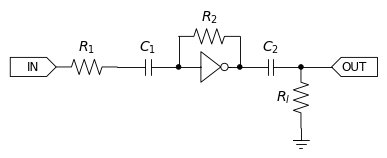

In [56]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)
d.add(elm.Tag('left', label='IN'))
R = d.add(elm.Resistor(label='$R_1$'))
d.add(elm.Capacitor(label='$C_1$'))
N = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_2$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Tag('right', label='OUT'))

d.draw()

this is the first setup with the 4069 as voltage follower. C1 and C3 are the dc blocking capacitors. when we choose R1 and R2 as 100kOhm we would excpect a gain of one. 

In [57]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)


In [58]:
buffer_data = []
for r in (100@u_kΩ, 125@u_kΩ, 150@u_kΩ, 175@u_kΩ, 200@u_kΩ):
    circuit.R2.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms)
    buffer_data.append(np.array(analysis['OUT']))


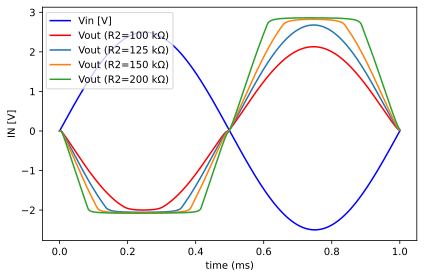

In [59]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[0], color='Red')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[1])
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[2])
#ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[3], color='#E97451')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[4])
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)', 'Vout (R2=150 kΩ)', 'Vout (R2=200 kΩ)'), loc=(0.01,0.65))

plt.tight_layout()
plt.show()

the blue line is the input signal (5V p2p) and the red the output signal with 100kOhm resistors. the output is a little less then excpected. for the other signals the resistor R2 is replaced with 125kΩ, 150kΩ, 175kΩ and 200kΩ. with 150kΩ the gain is roughly one. we also see that the ouput is not symetrical. the clipping occures earlier for the negative part of the signal. with higher gain the signal is soft clipped. 

## distortion
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

the soft clipping, which is the special characteristic of valves, adds harmonics to the signal. Here we want to analyse what harmonics are added. therefore we add a second stage to out circuit. the first stage is a voltage follower with the gain of one (or less as saw). the second stage is a high gain stage. the simulation is done with different values for R4.

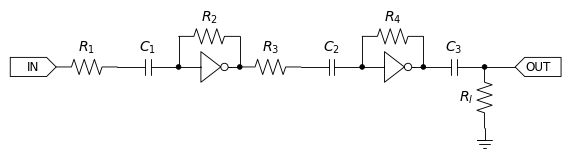

In [60]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)
d.add(elm.Tag('left', label='IN'))
R1 = d.add(elm.Resistor(label='$R_1$'))
d.add(elm.Capacitor(label='$C_1$'))
N1 = d.add(logic.Not)

R2 = d.add(elm.Resistor( label='$R_3$'))
d.add(elm.Capacitor(label='$C_2$'))
N2 = d.add(logic.Not)


C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_4$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Tag('right', label='OUT'))

d.draw()

in the simulation R2 is unchanched. For R4 the simulation is done with 100kΩ, 500kΩ, 1MΩ and 10MΩ.

In [61]:
circuit = Circuit('cmos buffer with distortion')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.R(2, 'gate_out_1', 'gate_in_1', 100@u_kΩ)
circuit.C(9, 'gate_out_1', 'gate_in_1', 100@u_pF)
circuit.C(1, 'gate_in_1', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.R(3, 'gate_out_1', 'r3_out', 100@u_kΩ)
circuit.C(2, 'r3_out', 'gate_in_2', 100@u_nF)
circuit.R(4, 'gate_in_2', 'gate_out_2', 300@u_kΩ)
circuit.C(5, 'gate_in_2', 'gate_out_2', 100@u_pF)

circuit.C(3, 'gate_out_2', 'OUT', 1@u_uF)
R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

In [62]:
buffer_data = []
for r in (100@u_kΩ, 150@u_kΩ, 500@u_kΩ, 1@u_MΩ, 10@u_MΩ):
    circuit.R4.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    #analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms)
    buffer_data.append(np.array(analysis['OUT']))

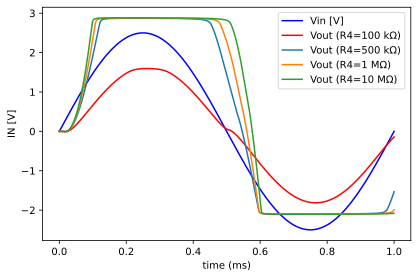

In [63]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[0], color='Red')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[2])
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[3])
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[4])
ax1.legend(('Vin [V]', 'Vout (R4=100 kΩ)', 'Vout (R4=500 kΩ)', 'Vout (R4=1 MΩ)', 'Vout (R4=10 MΩ)'), loc=(0.64,0.65))


plt.tight_layout()
plt.show()

the simulation looks similar to the first one. we can see that the signal is transforming into a square wave, but always with the soft clipping. next we want to analyse the harmonics that are added to the signal.

## *references*
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

1. [CD4069](https://www.ti.com/lit/ds/schs054e/schs054e.pdf) Datasheet
2. [UBE Screamer](http://www.runoffgroove.com/ubescreamer.html) TS-808 workalike built around the CD4049UBE logic IC
3. [WASP Filter](https://www.schmitzbits.de/wasp.html) Jürgen Haibles clone of the EDP Wasp VCF from René Schmitz.